In [1]:
# Load project functions
import crypto_monetary_base as cmb

In [2]:
import pandas as pd
import datetime
from tqdm import tqdm_notebook

import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set()
plt.rcParams['figure.figsize'] = (6, 4)
plt.rcParams['axes.labelpad'] = 10
mpl.rc('text', usetex=True)
plt.style.use('ggplot')

from IPython.display import display

In [3]:
%load_ext version_information
%version_information pandas, matplotlib, seaborn

Software versions
Python 3.6.5 64bit [GCC 4.2.1 Compatible Clang 4.0.1 (tags/RELEASE_401/final)]
IPython 6.4.0
OS Darwin 16.7.0 x86_64 i386 64bit
pandas 0.23.0
matplotlib 2.2.2
seaborn 0.9.0
Wed Dec 26 11:22:59 2018 EST

## Supply Curve Calculation

In [4]:
COIN_SYMBOL = 'ETC'

In [5]:
def etc_block_supply_curve(
    num_blocks,
    premine_amount=(72 * 1e6),
    output_granularity=10000,
    ):
    out = [
        # Block num,
        # Total supply - ETC,
        # Total supply - ETH,
    ]
    
    # Get original block reward by 
    # taking 26% of 60M premine, and
    # dividing by 2102400 blocks per
    # year (assuming 15 second blocks)
    whitepaper_block_reward = 7.42
    
    # Start "current plan" block rewards
    etc_block_reward = whitepaper_block_reward
    eth_block_reward = whitepaper_block_reward
    
    y_1 = premine_amount
    y_2 = premine_amount
    for block in tqdm_notebook(range(1, num_blocks+1)):
#         if block == 2500000:
#             pass
            # ETC diverges from ETH
            # Adjust to 14 ETC block reward
            # as documented in ECIP-1017
#             etc_block_reward = 14
        if block == 2700000:
            # Adjust to 5 ETH block reward
            # quoted in EIP-186
            eth_block_reward = 5
            etc_block_reward = 5
        elif block == 3700000:
            # Adjust to 4 ETH block reward
            # as per EIP-186
            eth_block_reward = 4
            etc_block_reward = 4
        elif block == 5000000:
            # Adjust to 3 ETH block reward
            # as per EIP-186
            eth_block_reward = 3
            # Adjust to 4.5 ETC block reward
            # as documented in ECIP-1017            
            etc_block_reward = 4.5
        elif block == 7000000:
            # Adjust to 2 ETH block reward
            # as per EIP-186
            eth_block_reward = 2
        elif block > 8000000:
            # Adjust to 1.5% annual
            # ETH block reward for PoS
            eth_block_reward = (
                (y_2 * 0.015) / 2102400
            )

        if block >= 10000000:
            if (block % 5000000) == 0:
                # Deflate by 20%
                etc_block_reward = etc_block_reward * 0.8
            
        y_1 += etc_block_reward
        y_2 += eth_block_reward
        
        if (block-1) % output_granularity == 0:
            out.append([block, y_1, y_2])

    return out

In [6]:
def datetime_etc_supply_curve(
    start_date,
    block_time,
    block_supply,
    output_granularity=10000,
    ):
    df = pd.DataFrame(
        block_supply, columns=['block', 'etc', 'eth']
    )
    df['etc_pct'] = (
        df['etc'] / df['etc'].values[-1]
        * 100
    )
    df['eth_pct'] = (
        df['eth'] / df['eth'].values[-1]
        * 100
    )
    df['date'] = pd.date_range(
        start=start_date,
        freq=block_time * output_granularity,
        periods=len(df)
    )
    return df

def plot_etc_supply_curve(
    supply,
    coin_name='ETC',
    plot_pct=False,
    max_size=10000,
    out_name='',
    ):
    max_size = min((max_size, len(supply)))
    step_size = int(len(supply) / max_size)
    dates = mpl.dates.date2num(supply.date.values[::step_size])
    
    # ETC
    if plot_pct:
        values = supply.etc_pct.values[::step_size]
    else:
        values = supply.etc.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='-',
        lw=4,
        label='ETC supply',
    )
    
    # ETH
    if plot_pct:
        values = supply.eth_pct.values[::step_size]
    else:
        values = supply.eth.values[::step_size]
    plt.plot_date(
        dates,
        values,
        fmt='--',
        lw=4,
        label='ETH supply',
    )
    
    # Plot current date
    mask = supply.date > datetime.datetime.now()
    current_supply = supply[mask].iloc[0]
    dates = mpl.dates.date2num([current_supply.date])
    if plot_pct:
        values = [current_supply.etc_pct]
    else:
        values = [current_supply.etc]
    plt.plot(
        dates,
        values,
        'o',
        color='black',
        ms=6,
        label=current_supply.date.strftime('%Y'),
    )
    
    plt.title(
        fr'$\textbf{{{coin_name}}}$ Monetary Base',
        y=1.05
    )
    plt.legend()
    
    ax = plt.gca()
    if plot_pct:
        ax.yaxis.set_major_formatter(mpl.ticker.PercentFormatter())
    
    if not out_name:
        out_name = coin_name
    plt.savefig(
        f'../charts/{out_name}.png',
        bbox_inches='tight',
        dpi=300
    )
    return plt

In [7]:
# ETC parameters
start_date = datetime.date(2015, 7, 30)
end_date = datetime.date(2140, 10, 7)
block_time = datetime.timedelta(seconds=15)

num_blocks = int(
    ((end_date - start_date).days * 24 * 3600)
    / block_time.seconds
)

block_supply = etc_block_supply_curve(
    num_blocks=num_blocks,
)

supply = datetime_etc_supply_curve(
    start_date=start_date,
    block_time=block_time,
    block_supply=block_supply,
)

In [8]:
display(supply.head())
display(supply.tail())

,block,etc,eth,etc_pct,eth_pct,date
0,1,7.200001e+07,7.200001e+07,33.530034,10.561781,2015-07-30 00:00:00
1,10001,7.207421e+07,7.207421e+07,33.564588,10.572666,2015-07-31 17:40:00
2,20001,7.214841e+07,7.214841e+07,33.599143,10.583550,2015-08-02 11:20:00
3,30001,7.222261e+07,7.222261e+07,33.633697,10.594435,2015-08-04 05:00:00
4,40001,7.229681e+07,7.229681e+07,33.668252,10.605319,2015-08-05 22:40:00


,block,etc,eth,etc_pct,eth_pct,date
26333,263330001,2.147329e+08,6.815088e+08,99.999999,99.971465,2140-09-29 00:20:00
26334,263340001,2.147329e+08,6.815574e+08,99.999999,99.978598,2140-09-30 18:00:00
26335,263350001,2.147329e+08,6.816060e+08,100.000000,99.985732,2140-10-02 11:40:00
26336,263360001,2.147329e+08,6.816546e+08,100.000000,99.992866,2140-10-04 05:20:00
26337,263370001,2.147329e+08,6.817033e+08,100.000000,100.000000,2140-10-05 23:00:00


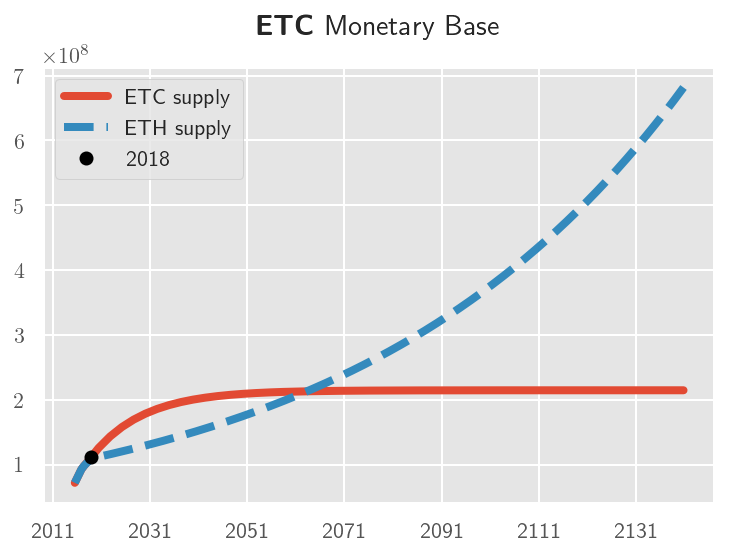

In [9]:
plot_etc_supply_curve(supply);

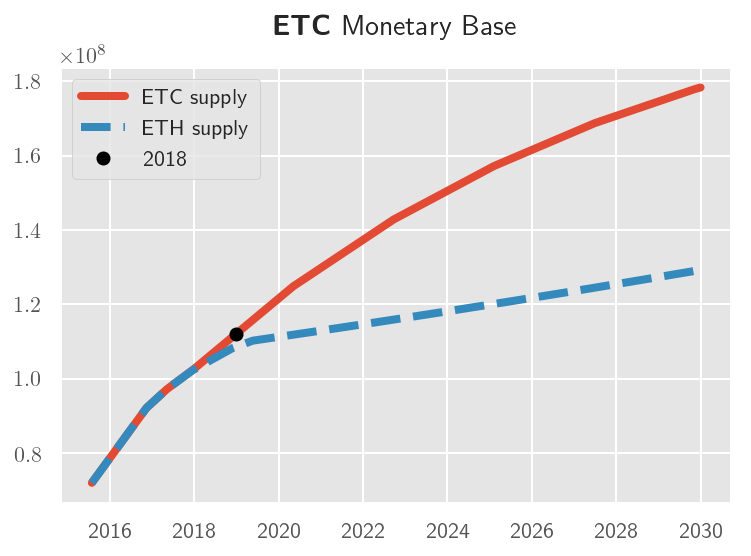

In [10]:
mask = supply.date < datetime.datetime(2030, 1, 1)
plot_etc_supply_curve(supply[mask], out_name='ETC_zoom');

## Standardize Time Series

In [11]:
weekly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='weekly')

display(weekly_supply.head())
display(weekly_supply.tail())

Wrote 6533 lines to file ../output-data/ETC_weekly.csv


,coin,block,etc,eth,etc_pct,eth_pct,date
0,ETC,1,7.200001e+07,7.200001e+07,33.530034,10.561781,2015-07-01
1,ETC,30001,7.222261e+07,7.222261e+07,33.633697,10.594435,2015-08-01
2,ETC,70001,7.251941e+07,7.251941e+07,33.771916,10.637973,2015-08-01
3,ETC,110001,7.281621e+07,7.281621e+07,33.910134,10.681511,2015-08-01
4,ETC,150001,7.311301e+07,7.311301e+07,34.048352,10.725049,2015-08-01


,coin,block,etc,eth,etc_pct,eth_pct,date
6528,ETC,263200001,2.147329e+08,6.808769e+08,99.999996,99.878784,2140-09-01
6529,ETC,263240001,2.147329e+08,6.810713e+08,99.999997,99.907292,2140-09-01
6530,ETC,263280001,2.147329e+08,6.812657e+08,99.999998,99.935808,2140-09-01
6531,ETC,263320001,2.147329e+08,6.814601e+08,99.999999,99.964333,2140-09-01
6532,ETC,263360001,2.147329e+08,6.816546e+08,100.000000,99.992866,2140-10-01


In [12]:
monthly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='monthly')

display(monthly_supply.head())
display(monthly_supply.tail())

Wrote 1504 lines to file ../output-data/ETC_monthly.csv


,coin,block,etc,eth,etc_pct,eth_pct,date
0,ETC,1,7.200001e+07,7.200001e+07,33.530034,10.561781,2015-07-01
1,ETC,20001,7.214841e+07,7.214841e+07,33.599143,10.583550,2015-08-01
2,ETC,200001,7.348401e+07,7.348401e+07,34.221125,10.779471,2015-09-01
3,ETC,370001,7.474541e+07,7.474541e+07,34.808552,10.964508,2015-10-01
4,ETC,550001,7.608101e+07,7.608101e+07,35.430534,11.160429,2015-11-01


,coin,block,etc,eth,etc_pct,eth_pct,date
1499,ETC,262640001,2.147328e+08,6.781620e+08,99.999983,99.480521,2140-06-01
1500,ETC,262820001,2.147329e+08,6.790335e+08,99.999987,99.608360,2140-07-01
1501,ETC,263000001,2.147329e+08,6.799061e+08,99.999991,99.736364,2140-08-01
1502,ETC,263170001,2.147329e+08,6.807312e+08,99.999995,99.857408,2140-09-01
1503,ETC,263350001,2.147329e+08,6.816060e+08,100.000000,99.985732,2140-10-01


In [13]:
yearly_supply = cmb.transform_supply(supply, COIN_SYMBOL, freq='yearly')

display(yearly_supply.head())
display(yearly_supply.tail())

Wrote 126 lines to file ../output-data/ETC_yearly.csv


,coin,block,etc,eth,etc_pct,eth_pct,date
0,ETC,1,7.200001e+07,7.200001e+07,33.530034,10.561781,2015-07-01
1,ETC,900001,7.867801e+07,7.867801e+07,36.639944,11.541386,2016-01-01
2,ETC,3010001,9.358400e+07,9.358400e+07,43.581589,13.727967,2017-01-01
3,ETC,5110001,1.027290e+08,1.025640e+08,47.840368,15.045255,2018-01-01
4,ETC,7210001,1.121790e+08,1.086540e+08,52.241185,15.938606,2019-01-01


,coin,block,etc,eth,etc_pct,eth_pct,date
121,ETC,253350001,2.147323e+08,6.346697e+08,99.999708,93.100584,2136-01-01
122,ETC,255460001,2.147324e+08,6.442965e+08,99.999784,94.512744,2137-01-01
123,ETC,257560001,2.147326e+08,6.540226e+08,99.999846,95.939479,2138-01-01
124,ETC,259670001,2.147327e+08,6.639429e+08,99.999909,97.394699,2139-01-01
125,ETC,261770001,2.147328e+08,6.739655e+08,99.999962,98.864938,2140-01-01
